# Swin Unet実装

In [14]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [15]:
# https://github.com/HuCaoFighting/Swin-Unet/blob/main/networks/swin_transformer_unet_skip_expand_decoder_sys.py

In [16]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super(Mlp, self).__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [17]:
def window_partition(x, window_size):
    """
    Args:
        x:(B, H, W, C)
        window_size (int): window size
    
    Return:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H//window_size,window_size, W//window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H*W/window_size/window_size))
    x = windows.view(B, H//window_size,window_size,W//window_size,window_size, -1)
    x = x.permute(0,1,3,2,4,5).contiguous().view(B, H, W, -1)
    return x


In [18]:
x = torch.rand(size=(16, 256, 256, 3))
windows = window_partition(x, 32)
window_reverse(windows,32,256, 256).shape

torch.Size([16, 256, 256, 3])

In [19]:
image = cv2.imread("../dataset/cat.jpg")
image = cv2.resize(image, (256,256))
image = torch.tensor(image, dtype=torch.float32).view(1, *image.shape)

In [20]:
def tensor2array(x):
    x = x.squeeze().detach().numpy().astype(np.uint8)
    return x

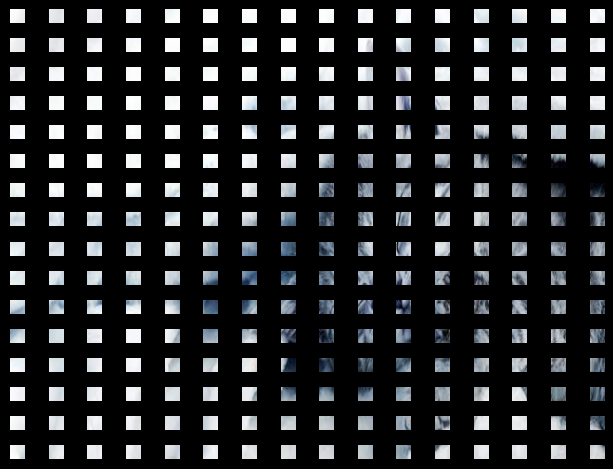

In [21]:
p = 4 
windows = window_partition(image, 2**p)
def plot(x):
    plt.imshow(tensor2array(x))

s = int((256//2**p))
for i in range(1,s**2+1):
    plt.subplot(s,s,i)
    plot(windows[i-1])
    plt.axis("off")
plt.tight_layout()
plt.show()

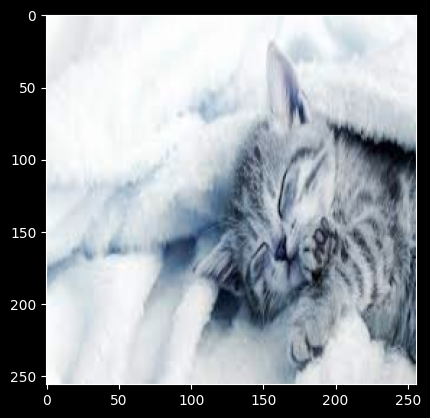

In [22]:
rev_x = window_reverse(windows, 2**p, 256,256)
plot(rev_x)

In [23]:
class WindowAttention(nn.Module):
    """ Window based multi-head self attention
    """
    def __init__(self, dim:int, window_size:tuple[int], num_heads:int, qkv_bias:bool=True, qk_scale:float=None, attn_drop:float=0., proj_drop:float=0.):
        """
        Args:
            dim (int): Number of input channels
            window_size (tuple[int]): The height and width of the window
            num_heads (int): Number of attention heads
            qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
            qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
            attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
            proj_drop (float, optional): Dropout ratio of output. Default: 0.0
        """
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size # Window height, Window width
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # difine a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2*window_size[0]-1)*(2*window_size[1]-1), num_heads) # 2Wh-1, 2Ww-1, num_heads
        )

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1) #2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :] # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0) # Wh*Ww, Wh*Ww, 2
        relative_position_index = relative_coords.sum(-1) #Wh*Wh, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x : input features with shape of (num_windows*B, N, C) 
            mask : (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4) #3, B_, num_heads, N, C//num_heads
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = (q @ k.transpose(-2 ,-1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1
            )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [24]:
# サンプルデータ
B = 1  # バッチサイズ
N = 64*64  # 各ウィンドウ内のトークン数 (例: 7x7のウィンドウ)
C = 3  # 入力チャンネル数
dim = 3  # 入力チャンネル数
window_size = (64, 64)  # ウィンドウサイズ (高さ, 幅)
num_heads = 3  # アテンションヘッドの数

In [25]:
windows = window_partition(image, 64)
windows.shape

torch.Size([16, 64, 64, 3])

In [27]:
window_attention = WindowAttention(dim=dim, window_size=window_size, num_heads=num_heads)
windows = windows.view(-1, N, C)
attn_windows = window_attention(windows)
attn = attn_windows.view(-1, 64, 64, C)
inv_attn = window_reverse(attn, 64, 256,256)


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [256, 3] but got: [256, 256].

In [ ]:

plot(inv_attn@image)

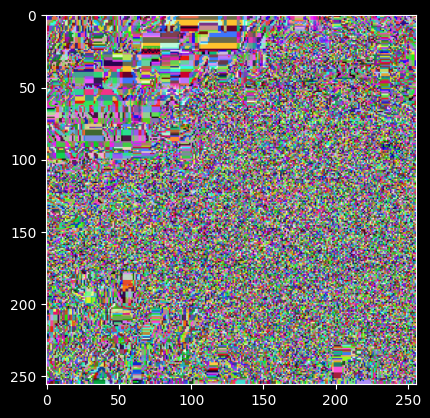

In [33]:
attned = torch.mul(inv_attn, image)
plot(attned)